In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Step 1: Convert Videos to Frames
def video_to_frames(video_dir, output_dir, frame_rate=1):
    """
    Convert training and testing videos to frames.
    Args:
        video_dir: Directory containing the videos (either training or testing).
        output_dir: Output directory to save extracted frames.
        frame_rate: Number of frames to capture per second.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for video_file in os.listdir(video_dir):
        video_path = os.path.join(video_dir, video_file)
        cap = cv2.VideoCapture(video_path)
        count = 0
        success, frame = cap.read()
        
        while success:
            if int(cap.get(cv2.CAP_PROP_POS_FRAMES)) % frame_rate == 0:
                frame_path = os.path.join(output_dir, f"frame_{video_file}_{count}.jpg")
                cv2.imwrite(frame_path, frame)
                count += 1
            success, frame = cap.read()
        cap.release()
    print(f"Frames extracted and saved in {output_dir}.")

# Step 2: Heuristic-Based Label Assignment
def assign_labels_heuristic(frame_dir, split_ratio=0.5):
    """
    Assign labels to frames based on a simple heuristic (e.g., first half normal, second half anomalous).
    Args:
        frame_dir: Directory where the frames are saved.
        split_ratio: Ratio to split normal and anomalous frames. Default is 50% normal, 50% anomalous.
    Returns:
        A list of frame paths and their corresponding labels.
    """
    frames = sorted(os.listdir(frame_dir), key=lambda x: int(x.split('_')[-1].split('.')[0]))
    total_frames = len(frames)
    normal_cutoff = int(total_frames * split_ratio)
    
    labels = []
    for i, frame in enumerate(frames):
        frame_path = os.path.join(frame_dir, frame)
        if i < normal_cutoff:
            labels.append((frame_path, 0))  # Label as normal
        else:
            labels.append((frame_path, 1))  # Label as anomaly
    
    return labels

# Step 3: Build the CNN-RNN Hybrid Model
def build_cnn_rnn_model(input_shape, num_classes=2):
    """
    Build a CNN-RNN hybrid model.
    Args:
        input_shape: Shape of the input frames (height, width, channels).
        num_classes: Number of classes (normal and anomaly).
    Returns:
        A CNN-RNN model.
    """
    cnn_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base CNN layers to use them as feature extractors
    for layer in cnn_base.layers:
        layer.trainable = False
    
    model = Sequential()

    # TimeDistributed CNN for extracting features from each frame
    model.add(TimeDistributed(cnn_base, input_shape=(None, input_shape[0], input_shape[1], input_shape[2])))
    model.add(TimeDistributed(Flatten()))

    # RNN Layer (LSTM/GRU) to model temporal dependencies
    model.add(LSTM(64, return_sequences=False))

    # Fully connected layer for classification
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Step 4: Load Data and Labels
def load_data_and_labels(frame_labels):
    """
    Load frames and their labels.
    Args:
        frame_labels: List of (frame path, label) pairs.
    Returns:
        Numpy arrays of images and labels.
    """
    images, labels = [], []
    for frame, label in frame_labels:
        img = cv2.imread(frame)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(label)
    
    images = np.array(images)
    labels = to_categorical(labels, 2)  # 2 classes: normal (0) and anomaly (1)
    return images, labels

# Step 5: Train and Evaluate the Model with Metrics
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Train the CNN-RNN hybrid model with data augmentation and evaluate it.
    Calculate the testing accuracy, precision, recall, F1 score, and show the confusion matrix.
    """
    datagen = ImageDataGenerator()

    # Train the model
    model.fit(datagen.flow(X_train, y_train, batch_size=32),
              validation_data=(X_test, y_test),
              epochs=20)

    # Predictions and metrics
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    test_acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Example Workflow

# Set directories for training and testing videos
train_video_dir = 'Avenue_Dataset/Avenue Dataset/training_videos'  # Path to training videos folder
test_video_dir = 'Avenue_Dataset/Avenue Dataset/testing_videos'  # Path to testing videos folder

# Output directories for frames
train_frame_output_dir = 'frames_avenue/train_frames'
test_frame_output_dir = 'frames_avenue/test_frames'

# Step 1: Convert training and testing videos to frames
video_to_frames(train_video_dir, train_frame_output_dir)  # Convert training videos
video_to_frames(test_video_dir, test_frame_output_dir)  # Convert testing videos

# Check if frames were extracted properly
print(f"Training frames extracted: {len(os.listdir(train_frame_output_dir))}")
print(f"Testing frames extracted: {len(os.listdir(test_frame_output_dir))}")

# Step 2: Assign labels heuristically
train_labels = assign_labels_heuristic(train_frame_output_dir, split_ratio=0.5)  # 50% normal, 50% anomaly
test_labels = assign_labels_heuristic(test_frame_output_dir, split_ratio=0.5)

# Step 3: Load the data (frames and labels)
X_train, y_train = load_data_and_labels(train_labels)
X_test, y_test = load_data_and_labels(test_labels)

# Check the shape of the training and testing data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Step 4: Build the model
input_shape = (224, 224, 3)  # Assuming each frame is resized to 224x224 with 3 color channels
model = build_cnn_rnn_model(input_shape)

# Step 5: Train and evaluate the model with metrics
train_and_evaluate_model(model, X_train, y_train, X_test, y_test)


Frames extracted and saved in frames_avenue/train_frames.
Frames extracted and saved in frames_avenue/test_frames.
Training frames extracted: 15328
Testing frames extracted: 15324
X_train shape: (15328, 224, 224, 3), y_train shape: (15328, 2)
X_test shape: (15324, 224, 224, 3), y_test shape: (15324, 2)
Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 224, 224, 3), dtype=float32). Expected shape (None, None, 224, 224, 3), but input has incompatible shape (None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None

Epoch 1/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1415s 3s/step - accuracy: 0.9799 - loss: 0.1173 - val_accuracy: 0.4991 - val_loss: 4.2581
Epoch 2/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1432s 3s/step - accuracy: 0.7198 - loss: 1.1413 - val_accuracy: 0.4990 - val_loss: 1.0828
Epoch 3/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1434s 3s/step - accuracy: 0.2516 - loss: 1.0105 - val_accuracy: 0.4990 - val_loss: 0.7247
Epoch 4/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1433s 3s/step - accuracy: 0.2229 - loss: 0.8001 - val_accuracy: 0.4990 - val_loss: 0.7080
Epoch 5/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1433s 3s/step - accuracy: 0.2134 - loss: 0.7710 - val_accuracy: 0.4990 - val_loss: 0.7036
Epoch 6/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1434s 3s/step - accuracy: 0.2474 - loss: 0.7954 - val_accuracy: 0.4990 - val_loss: 0.7106
Epoch 7/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1434s 3s/step - accuracy: 0.1672 - loss: 0.7891 - val_accuracy: 0.4990 - val_loss: 0.7058
Epoch 8/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1433s 3s/step - accuracy: 0.1994 - loss: 0.7685 - 

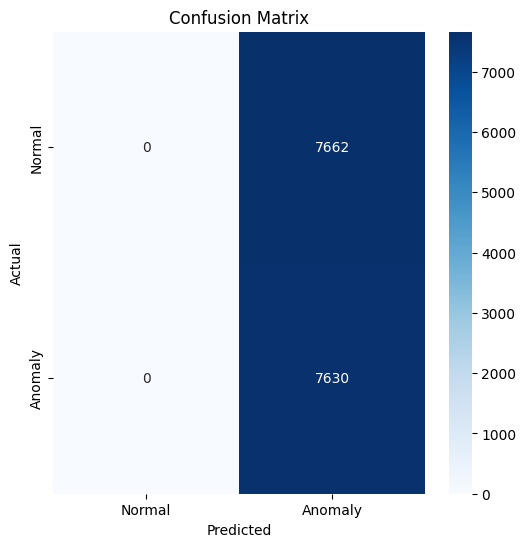

In [7]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Step 1: Heuristic-Based Label Assignment
def assign_labels_heuristic(frame_dir, split_ratio=0.5):
    frames = sorted(os.listdir(frame_dir), key=lambda x: int(x.split('_')[-1].split('.')[0]))
    total_frames = len(frames)
    normal_cutoff = int(total_frames * split_ratio)
    
    labels = []
    for i, frame in enumerate(frames):
        frame_path = os.path.join(frame_dir, frame)
        if i < normal_cutoff:
            labels.append((frame, 0))  # Label as normal
        else:
            labels.append((frame, 1))  # Label as anomaly
    
    return labels

# Step 2: Build the CNN-RNN Hybrid Model
def build_cnn_rnn_model(input_shape, num_classes=2):
    cnn_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base CNN layers to use them as feature extractors
    for layer in cnn_base.layers:
        layer.trainable = False
    
    model = Sequential()

    # TimeDistributed CNN for extracting features from each frame
    model.add(TimeDistributed(cnn_base, input_shape=(None, input_shape[0], input_shape[1], input_shape[2])))
    model.add(TimeDistributed(Flatten()))

    # RNN Layer (LSTM/GRU) to model temporal dependencies
    model.add(LSTM(64, return_sequences=False))

    # Fully connected layer for classification
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Step 3: Generator to Load Data in Batches
def data_generator(frame_labels, frame_dir, batch_size=32):
    while True:
        for start in range(0, len(frame_labels), batch_size):
            end = min(start + batch_size, len(frame_labels))
            batch_labels = frame_labels[start:end]
            images, labels = [], []
            for frame, label in batch_labels:
                frame_path = os.path.join(frame_dir, frame)
                img = cv2.imread(frame_path)

                if img is None:  # Check if the image is loaded correctly
                    print(f"Warning: Failed to load image {frame_path}. Skipping this frame.")
                    continue
                
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label)
            
            images = np.array(images)
            labels = to_categorical(labels, 2)  # 2 classes: normal (0) and anomaly (1)
            
            # Add a time dimension (1) to make the data compatible with the RNN input
            images = np.expand_dims(images, axis=1)  # Shape: (batch_size, 1, 224, 224, 3)
            yield images, labels

# Step 4: Train and Evaluate the Model with Metrics
def train_and_evaluate_model(model, train_gen, test_gen, train_size, test_size, batch_size=32, epochs=10):
    # Train the model using the generator
    model.fit(train_gen, steps_per_epoch=train_size // batch_size, 
              validation_data=test_gen, validation_steps=test_size // batch_size,
              epochs=epochs)

    # Evaluate the model using the generator
    y_pred, y_true = [], []
    for i in range(test_size // batch_size):
        X_batch, y_batch = next(test_gen)
        y_batch_pred = np.argmax(model.predict(X_batch), axis=1)
        y_batch_true = np.argmax(y_batch, axis=1)
        y_pred.extend(y_batch_pred)
        y_true.extend(y_batch_true)

    # Calculate metrics
    test_acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Example Workflow

# Output directories for frames (already extracted)
train_frame_output_dir = 'frames_avenue/train_frames'
test_frame_output_dir = 'frames_avenue/test_frames'

# Step 1: Assign labels heuristically to pre-extracted frames
train_labels = assign_labels_heuristic(train_frame_output_dir, split_ratio=0.5)  # 50% normal, 50% anomaly
test_labels = assign_labels_heuristic(test_frame_output_dir, split_ratio=0.5)

# Step 2: Get the sizes of the train and test sets
train_size = len(train_labels)
test_size = len(test_labels)

# Step 3: Create the data generators for training and testing
train_gen = data_generator(train_labels, train_frame_output_dir, batch_size=32)
test_gen = data_generator(test_labels, test_frame_output_dir, batch_size=32)

# Step 4: Build the model
input_shape = (224, 224, 3)  # Shape for each frame
model = build_cnn_rnn_model(input_shape)

# Step 5: Train and evaluate the model using the generators
train_and_evaluate_model(model, train_gen, test_gen, train_size, test_size, batch_size=32, epochs=10)
